In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import numpy as np
from sklearn.linear_model import LinearRegression

#### Import and Cleaning the Data

In [2]:
#import function to filter selected countries and year, and rename the columns
sys.path.append('../src/Import_and_Cleaning')
from cleaning_data import dependency_ratio_data, dependency_ratio_old, dependency_ratio_young, clean_health_data, clean_education, GDP_percapita, clean_income_level, population, average_schooling, learning_outcome, life_expectancy, mortality, clean_income_level

In [3]:
sys.path.append('../src/visualization')
from age_dist_visual import set_seaborn_style, create_age_distribution, format_ticks, add_legend, create_image_from_figure, add_padding_to_chart, generate_country_figure, create_grid

In [4]:
df_health = clean_health_data(
    '../data/raw/health_expenditure_raw.csv', #input
    '../data/processed/health_expenditure_clean.csv' #output
)

df_Education = clean_education(
    '../data/raw/Education_expenditure_raw.csv',
    '../data/processed/Education_expenditure_clean.csv'
)

df_dependency = dependency_ratio_data(
    '../data/raw/dependency_ratio_raw.csv', 
    '../data/processed/dependency_ratio_clean.csv' 
)

df_dependency_old = dependency_ratio_old(
    '../data/raw/dependency_ratio_old_raw.csv', 
    '../data/processed/dependency_ratio_old_clean.csv' 
)

df_dependency_young = dependency_ratio_young(
    '../data/raw/dependency_ratio_young_raw.csv', 
    '../data/processed/dependency_ratio_young_clean.csv' 
)

df_GDP_percapita = GDP_percapita(
    '../data/raw/GDP_percapita.csv',
    '../data/processed/GDP_percapita_clean.csv'
)

df_population = population(
    '../data/raw/pop_total.csv',
    '../data/processed/pop_total_clean.csv'
)

df_income_level = clean_income_level(
    '../data/raw/Income_level_raw.xlsx',
    '../data/processed/income_level_clean.csv'
)

df_average_schooling = average_schooling(
    '../data/raw/average_schooling_raw.csv',
    '../data/processed/average_schooling_clean.csv'
)

df_learing_outcome = learning_outcome(
    '../data/raw/learning_outcome_raw.csv',
    '../data/processed/learning_outcome_clean.csv'
)

df_life_expectancy = life_expectancy(
    '../data/raw/life_expectancy_raw.csv',
    '../data/processed/life_expectancy_clean.csv'
)

df_mortality = mortality(
    '../data/raw/mortality_raw.csv',
    '../data/processed/mortality_clean.csv'
)

df_income_level = clean_income_level(
    '../data/raw/Income_level_raw.xlsx',
    '../data/processed/income_level_clean.csv'
)

/Users/gilang/Documents/GitHub/graspp-25S-fiscalpolicy/notebooks/../src/Import_and_Cleaning/cleaning_data.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Country'] = df_filtered['Country'].replace(COUNTRY_RENAME_MAP)
/Users/gilang/Documents/GitHub/graspp-25S-fiscalpolicy/notebooks/../src/Import_and_Cleaning/cleaning_data.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Country'] = df_filtered['Country'].replace(COUNTRY_RENAME_MAP)


In [5]:
population_ratio_female = pd.read_csv("../data/raw/secondary/population_ratio_female.csv", index_col=None)
population_ratio_male = pd.read_csv("../data/raw/secondary/population_ratio_male.csv", index_col=None)

In [6]:
# Set styles
font_family = "PT Mono"
background_color = "#253D5B"
grid_color = "#355882"
text_color = "#EEEEEE"
set_seaborn_style(font_family, background_color, grid_color, text_color)

#### Merged the Data

In [18]:
merged = df_health.merge(df_Education, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_dependency, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_dependency_old, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_dependency_young, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_life_expectancy, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_mortality, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_average_schooling, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_learing_outcome, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_GDP_percapita, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_population, on=["ISO3", "Year", "Country"], how="outer")
merged = merged.merge(df_income_level, on=["ISO3", "Country"], how="left")
merged["log_GDP_percapita"] = np.log(merged["GDP_percapita"])

merged.to_csv('../data/interim/merged_data.csv', index=False)

## Demographic Structure and Public Spending

### Age Distribution

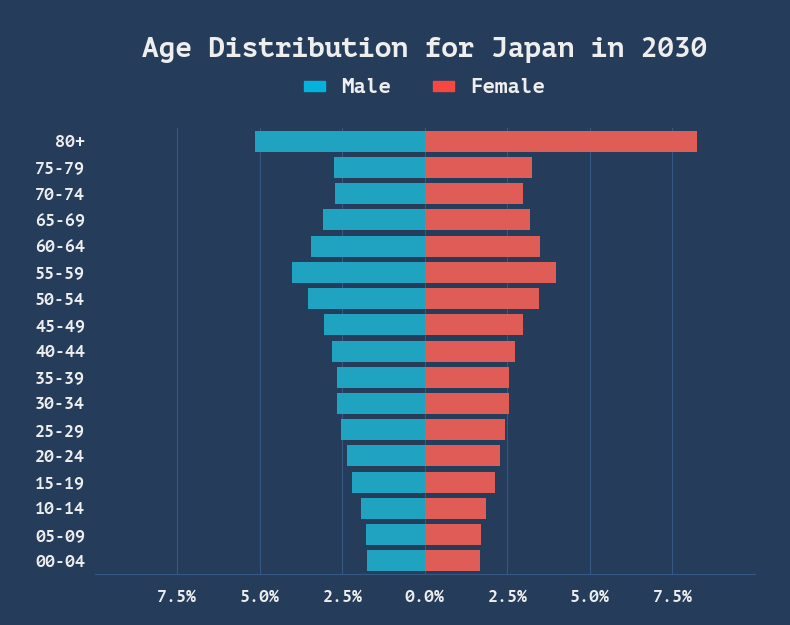

In [13]:
country_code = "JPN"
year = "2030"

country_name = population_ratio_female[population_ratio_female.country_code == country_code]["country_name"].iloc[0]
# Create plot
fig = plt.figure(figsize=(7.5, 6))
ax = create_age_distribution(population_ratio_female, population_ratio_male, country_code, year)
format_ticks(ax, xformat="percentage", xlim=(-10, 10))
add_legend(x=0.5, y=1.09, background_color=background_color)
plt.title(f"Age Distribution for {country_name} in {year}", y=1.14, fontsize=20)

# Convert to image and add padding
image = create_image_from_figure(fig)
image = add_padding_to_chart(image, 20, 20, 20, 5, background_color)
image

### Regression

$$
\text{HealthExp}_{it} = \beta_0 + \beta_1 \cdot \text{DepOld}_{it} + \beta_2 \cdot \text{DepYoung}_{it} + \beta_3 \cdot \text{LnGDPpc}_{it} + \epsilon_{it}
$$

- $\beta_0$: constant term  
- $\beta_1$: effect of aging  
- $\beta_2$: effect of youth burden  
- $\beta_3$: effect of LnGDP per capita  
- $\epsilon_{it}$: error term for country $i$ in year $t$

In [24]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Filter data to years 2000–2022 and drop rows with missing values in key variables
df_model = df[
    (df["Year"] <= 2022) &
    df["Health_Expenditure"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["log_GDP_percapita"].notna()
]

# Run OLS regression
model = smf.ols(
    formula="Health_Expenditure ~ Dependency_Ratio_Old + Dependency_Ratio_Young + log_GDP_percapita",
    data=df_model
).fit()

# Print regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     392.4
Date:                Mon, 26 May 2025   Prob (F-statistic):          4.92e-179
Time:                        08:22:43   Log-Likelihood:                -2586.1
No. Observations:                1241   AIC:                             5180.
Df Residuals:                    1237   BIC:                             5201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

## Health and Education Expenditure Projections (to 2050)

### GDP per capita projection using log-linear regression

In [14]:
# Placeholder to collect all updated rows
results = []

# Loop by country
for country, group in merged.groupby("Country"):
    group = group.sort_values("Year").copy()

    # Use historical data with valid GDP up to 2023
    train = group[(group["Year"] <= 2023) & (group["log_GDP_percapita"].notna())]

    if len(train) >= 5:  # Ensure enough data points
        X = train[["Year"]]
        y = train["log_GDP_percapita"]

        # Train the model
        model = LinearRegression().fit(X, y)

        # Select future rows
        group_future = group[group["Year"] > 2023].copy()
        X_future = group_future[["Year"]]

        # Predict log(GDP)
        y_pred_log = model.predict(X_future)

        # Fill in both ln(GDP) and GDP
        group_future["log_GDP_percapita"] = y_pred_log
        group_future["GDP_percapita"] = np.exp(y_pred_log)

        # Update future rows in the original group
        group.update(group_future)

    results.append(group)

# Recombine all updated groups
merged_updated = pd.concat(results).reset_index(drop=True)



In [15]:
merged_updated

,Country,ISO3,Year,Health_Expenditure,Education_Expenditure,Dependency_Ratio,Dependency_Ratio_Old,Dependency_Ratio_Young,Life_Expectancy,Mortality_Rate,average_schooling,test_scores,GDP_percapita,Population,income_level,log_GDP_percapita
0,Argentina,ARG,2000,8.220011,4.58031,60.8399424011737,15.536780754278,45.3031616468956,73.910,16.7,8.802,NaN,7637.014892,37213984,Upper middle income,8.940762
1,Argentina,ARG,2001,8.371799,4.83374,60.442088771688,15.6034995940423,44.8385891776457,74.154,16.2,8.870,NaN,7141.475077,37624825,Upper middle income,8.873675
2,Argentina,ARG,2002,7.393312,4.01734,60.0100181534326,15.6661577646685,44.3438603887641,74.312,15.8,9.395,NaN,2569.699635,38029349,Upper middle income,7.851544
3,Argentina,ARG,2003,6.894516,3.53505,59.5157720560259,15.7037442216745,43.8120278343514,74.307,15.4,9.920,NaN,3320.477751,38424282,Upper middle income,8.107864
4,Argentina,ARG,2004,7.228683,3.48652,58.9908808603745,15.7354699936422,43.2554108667324,74.871,14.9,10.010,NaN,4242.020991,38815916,Upper middle income,8.352795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749,Vietnam,VNM,2046,NaN,NaN,54.5471562084152,27.7512801316737,26.7958760767416,NaN,NaN,NaN,NaN,82766.671546,109827659,Lower middle income,11.323781
2750,Vietnam,VNM,2047,NaN,NaN,55.4465881075574,28.5994909513612,26.8470971561962,NaN,NaN,NaN,NaN,92845.761338,109930239,Lower middle income,11.438695
2751,Vietnam,VNM,2048,NaN,NaN,56.4835415253703,29.5909896888388,26.8925518365316,NaN,NaN,NaN,NaN,104152.254010,109994024,Lower middle income,11.553609
2752,Vietnam,VNM,2049,NaN,NaN,57.577607008179,30.6630017444708,26.9146052637082,NaN,NaN,NaN,NaN,116835.619193,110018019,Lower middle income,11.668523
